In [1]:
import torch
import torch.nn as nn
from NARX import NARX
from ANARX import ANARX
import matplotlib.pyplot as plt
from tqdm import tqdm
from utilities import lag_matrix
from sysidentpy.utils.generate_data import get_siso_data
import scipy.io

from pathlib import Path
print(Path.cwd())


c:\Users\vh\Documents\Projektmodul\Valentin macht alles neu\unified


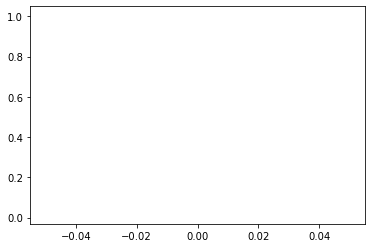

In [18]:
data = scipy.io.loadmat("data/1803")
input = data["u2_t"]
out = data["y_t"]

In [3]:
INPUT_LAGS = 6
OUTPUT_LAGS = 14

In [4]:
model = ANARX(14, [6], n_hidden=3, layersize= 10, afunc=torch.tanh, SANARX=True)

In [5]:
print(model)

ANARX(
  (subnets): ModuleList(
    (0): LAGNET(
      (linear_layers): ModuleList(
        (0): Linear(in_features=2, out_features=1, bias=True)
      )
    )
    (1): LAGNET(
      (linear_layers): ModuleList(
        (0): Linear(in_features=2, out_features=10, bias=True)
        (1): Linear(in_features=10, out_features=10, bias=True)
        (2): Linear(in_features=10, out_features=1, bias=True)
      )
    )
    (2): LAGNET(
      (linear_layers): ModuleList(
        (0): Linear(in_features=2, out_features=10, bias=True)
        (1): Linear(in_features=10, out_features=10, bias=True)
        (2): Linear(in_features=10, out_features=1, bias=True)
      )
    )
    (3): LAGNET(
      (linear_layers): ModuleList(
        (0): Linear(in_features=2, out_features=10, bias=True)
        (1): Linear(in_features=10, out_features=10, bias=True)
        (2): Linear(in_features=10, out_features=1, bias=True)
      )
    )
    (4): LAGNET(
      (linear_layers): ModuleList(
        (0): Linear(

In [20]:
out = torch.Tensor(out).squeeze()
input = torch.Tensor(input).squeeze()
in_lagged = lag_matrix(input, INPUT_LAGS)
out_lagged = lag_matrix(out, OUTPUT_LAGS)


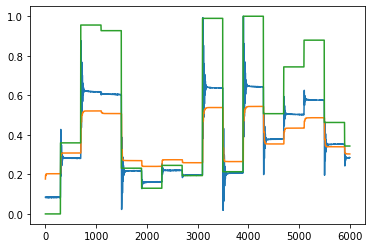

In [21]:
plt.plot(out.detach().numpy())
plt.plot(model.justpredict([input]).detach().numpy())

In [12]:
# Open Loop Training
optim = torch.optim.Adam(model.parameters())
crit = nn.MSELoss()
dataset = torch.utils.data.TensorDataset(in_lagged, out_lagged, out)
loader = torch.utils.data.DataLoader(dataset, batch_size=20, shuffle=False)
for epoch in tqdm(range(200)):
    for i1, ol, os in loader:
        optim.zero_grad()
        result = model(ol, [i1])
        # print(result)
        loss = crit(result, os)
        loss.backward()
        optim.step()

100%|██████████| 200/200 [09:35<00:00,  2.88s/it]


In [9]:
# Closed Loop Training
optim = torch.optim.Adam(model.parameters())
crit = nn.MSELoss()
for i in tqdm(range(1)):
    optim.zero_grad()
    pred = model.predict([input])
    loss = crit(pred, out)
    loss.backward()
    optim.step()

100%|██████████| 1/1 [00:30<00:00, 30.69s/it]


In [14]:
torch.save(model, "sanarx_14_5_test.pt")